In [1]:
from typing import List, Tuple, Dict, Union, Callable

import os
import sys
sys.path.append("..")

import multiprocessing as mp

import glob
import pathlib

import tqdm
tqdm.tqdm.pandas()

import json

import re

import numpy as np
import pandas as pd

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from src.misc import paths, utc_to_date
from src.topic import Top2VecViewer, generate_wordcloud
from src.classifiers import make_setfit_binary_predictor
from src.text import tokenize_text, normalize_text, text_to_sentences, get_similar_words_fasttext

## __Load Transcript Dataset__

In [2]:
class SEC10KLoader:

    def load(self):

        df_10k = pd.read_json(paths.item1a / "raw" / "item1a_full_scored_sents.json")
        df_10k.loc[:, "item1a_sentences"] = df_10k.loc[:, "item1a_sentences"].map(lambda ll: [s for l in ll for s in l])
        return df_10k
    
    def flush_processed(self, df: pd.DataFrame, name: str) -> pd.DataFrame:
        df.to_json(paths.item1a / "processed" / name, 
                   orient="records",
                   indent=4)
        return df
    
    def load_processed(self, name: str) -> pd.DataFrame:
        df = pd.read_json(paths.item1a / "processed" / name,
                          orient="records")
        return df


sec10k_loader = SEC10KLoader()

In [3]:
FROM_PROCESSED = True
if FROM_PROCESSED:
    df_10k = sec10k_loader.load_processed("item1a_with_attributes.json")
else:
    df_10k = sec10k_loader.load()
df_10k.head()

,symbol,filing_time,item1a,status,keywords,entities,noun_chunks,top8_key,top8_key_scr_all,top8_key_scr_avg,...,top8_ent_scr_avg,top8_ent_scr_min,top8_nck,top8_nck_scr_all,top8_nck_scr_avg,top8_nck_scr_min,item1a_sentences,topic_ids_cluster,topic_ids_pillar,is_action_probas
0,abml,2013-12-01,[The Risk Factors below are provided for a pot...,0,"[locate, think, call, lose, assurance, result,...","[oroplata, bylaw article incorporation, minist...","[government regulation, occasional spot shorta...","[accept, devote, hire, express, factor, achiev...","[24.00, 30.00, 3.00, 34.00, 8.00, 33.00, 17.00...",22.88,...,4.88,1,"[general economic political market condition, ...","[3.00, 3.00, 3.00, 3.00, 3.00, 3.00, 3.00, 3.00]",3.00,3,[The Risk Factors below are provided for a pot...,"[[-1], [1, 2], [-1], [-1], [2], [2], [-1], [-1...","[[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1...","[0.0976758732, 0.0636468605, 0.0086866519, 0.0..."
1,abml,2015-01-01,[The Risk Factors below are provided for a pot...,0,"[locate, lose, result, estimate, predict, slow...","[oroplata, mineral property, bylaw article inc...","[new mineral interest, material effect, near f...","[hire, factor, share, accept, express, devote,...","[3.00, 8.00, 17.00, 24.00, 34.00, 30.00, 41.00...",25.00,...,3.50,1,"[cash need, commercially exploitable reserve, ...","[3.00, 3.00, 3.00, 3.00, 3.00, 3.00, 3.00, 4.00]",3.12,3,[The Risk Factors below are provided for a pot...,"[[-1], [1, 2], [-1], [-1], [2], [2], [-1], [-1...","[[-1], [-1], [-1], [-1], [-1], [1], [-1], [-1]...","[0.057949447, 0.0636468605, 0.0086866519, 0.02..."
2,abml,2015-12-01,[We are a smaller reporting company as defined...,0,[],[security act],"[smaller reporting company, security act]","[pay, pass, penetrate, pende, perform, patent,...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,...,325.75,30,"[party site, party source, security act, party...","[368.00, 368.00, 16.00, 368.00, 368.00, 17.00,...",280.12,16,[We are a smaller reporting company as defined...,[[-1]],[[-1]],[0.496934639]
3,abml,2016-12-01,[We are a smaller reporting company as defined...,0,[],[security act],"[smaller reporting company, security act]","[pay, pass, penetrate, pende, perform, patent,...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,...,325.75,30,"[party site, party source, security act, party...","[368.00, 368.00, 16.00, 368.00, 368.00, 17.00,...",280.12,16,[We are a smaller reporting company as defined...,[[-1]],[[-1]],[0.496934639]
4,abml,2018-01-01,[Not required..],0,[require],[],[],"[penetrate, pay, perceive, require, permit, pe...","[368.00, 368.00, 368.00, 352.00, 368.00, 368.0...",366.00,...,368.00,368,"[party site, party source, party processing ac...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,368,[Not required..],[[-1]],[[-1]],[0.5228199227]


## __Assign Attributes to Earning's Call Transcripts__

### __Get Topic IDs__

In [4]:
# This global variable is also used in the `compute_statistics` function
topic_stoi_cluster = {
    # "environmental_regulation": 2,
    "customer_orientation":     4,
    "shareholder_affiliation":  6,
    "hiring_employees":         8,
    "natural_disaster":         9,
    "litigation":               11,
    "carbon_emissions":         12,
    "labor_issues":             13,
    "supply_chain_problems":    14,
    "taxes":                    15
}
topic_stoi_pillar = {
    "environmental": 0,
    "social":        1,
    "governance":    2,
}

topic_itos_cluster = {v: k for k, v in topic_stoi_cluster.items()}
topic_itos_pillar = {v: k for k, v in topic_stoi_pillar.items()}

id_map_cluster = list(topic_itos_cluster.keys())
id_map_pillar = list(topic_itos_pillar.keys())

In [5]:
t2v_viewer = Top2VecViewer.load(paths.t2v / "doc2vec-deep-learn-16-topics.pkl")

# Pair topic words with their scores
#   We will trim the topic words to keep only the relevant
#   ones for the topic using domain knowledge
topic_words = t2v_viewer.get_topic_words(topic_itos_cluster.keys(), top_k=25)
topic_words.loc[:, "topic_name"] = topic_words["topic_num"].map(lambda i: topic_itos_cluster[i])
topic_words.head()

,topic_num,keyword,cosine_score,topic_name
0,4,customer,0.4407,customer_orientation
1,4,demand,0.3292,customer_orientation
2,4,sale,0.3236,customer_orientation
3,4,margin,0.3184,customer_orientation
4,4,revenue,0.3043,customer_orientation


In [6]:
# Load trimmed topic words
topic_words = pd.read_csv(paths.data / "topics" / "topic_words_aj_th.csv")
topic_words = topic_words.loc[topic_words["suggest_delete_any"] != 1]
topic_words.head()

,topic_num,keyword,suggest_delete_anne,suggest_delete_tony,suggest_delete_any,suggest_delete_both,cosine_score,topic_name
0,4,customer,NaN,NaN,NaN,NaN,0.4407,customer_orientation
1,4,demand,NaN,NaN,NaN,NaN,0.3292,customer_orientation
2,4,sale,NaN,NaN,NaN,NaN,0.3236,customer_orientation
3,4,margin,NaN,NaN,NaN,NaN,0.3184,customer_orientation
4,4,revenue,NaN,NaN,NaN,NaN,0.3043,customer_orientation


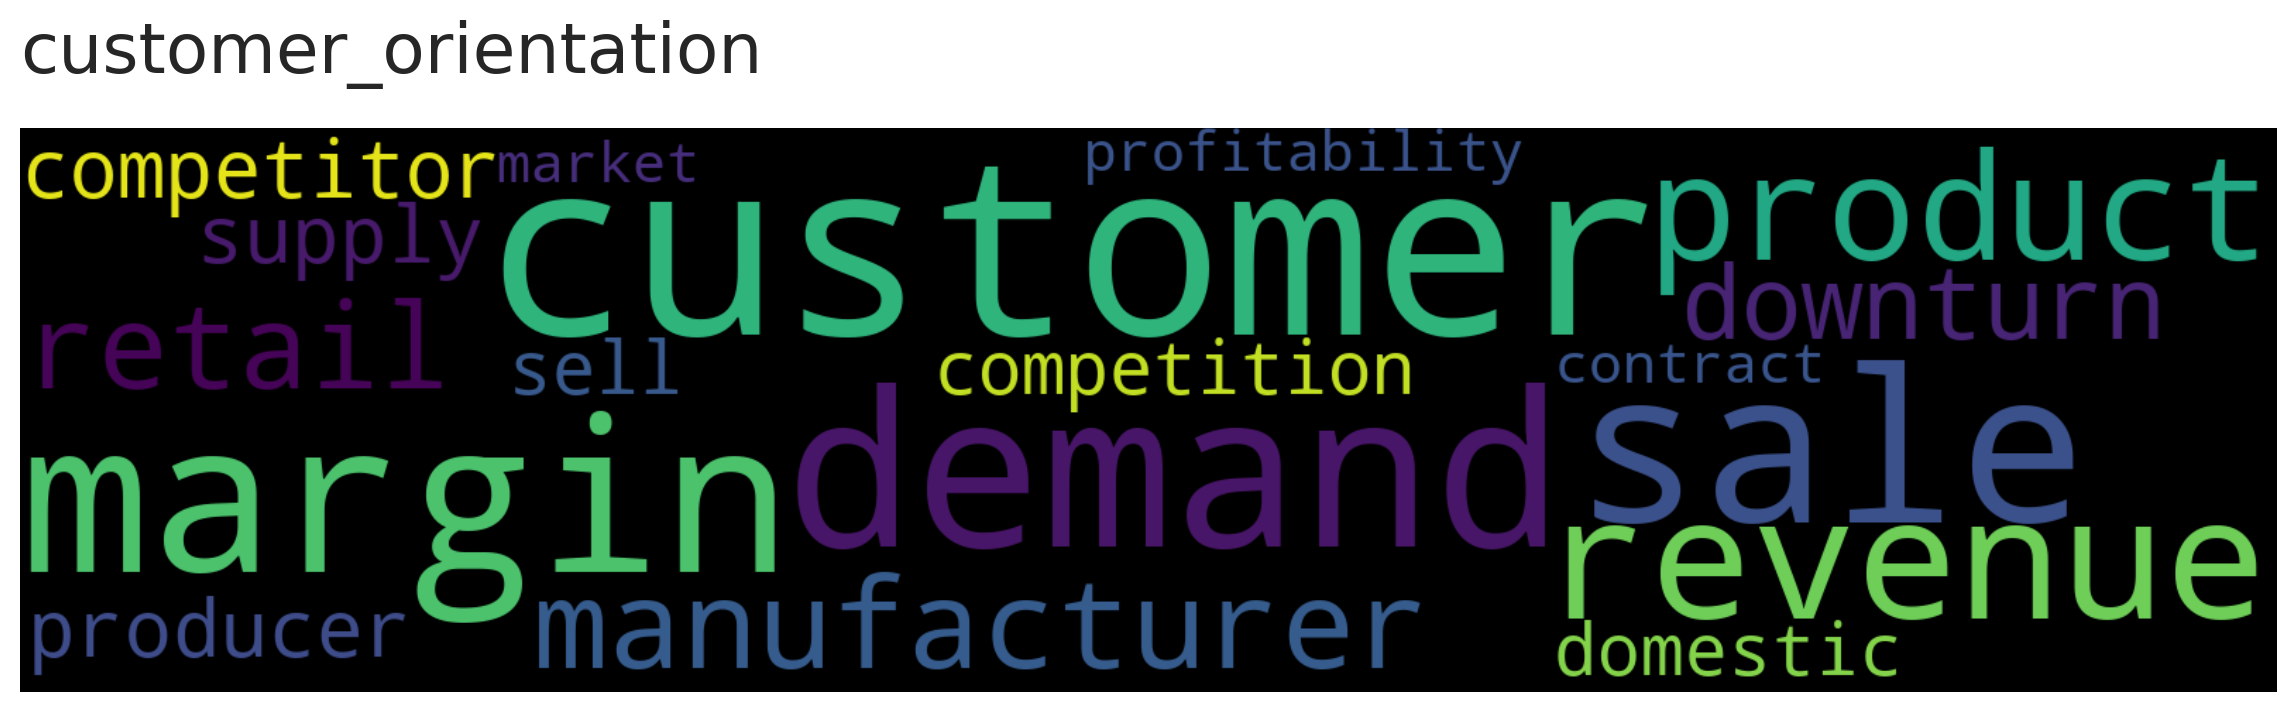

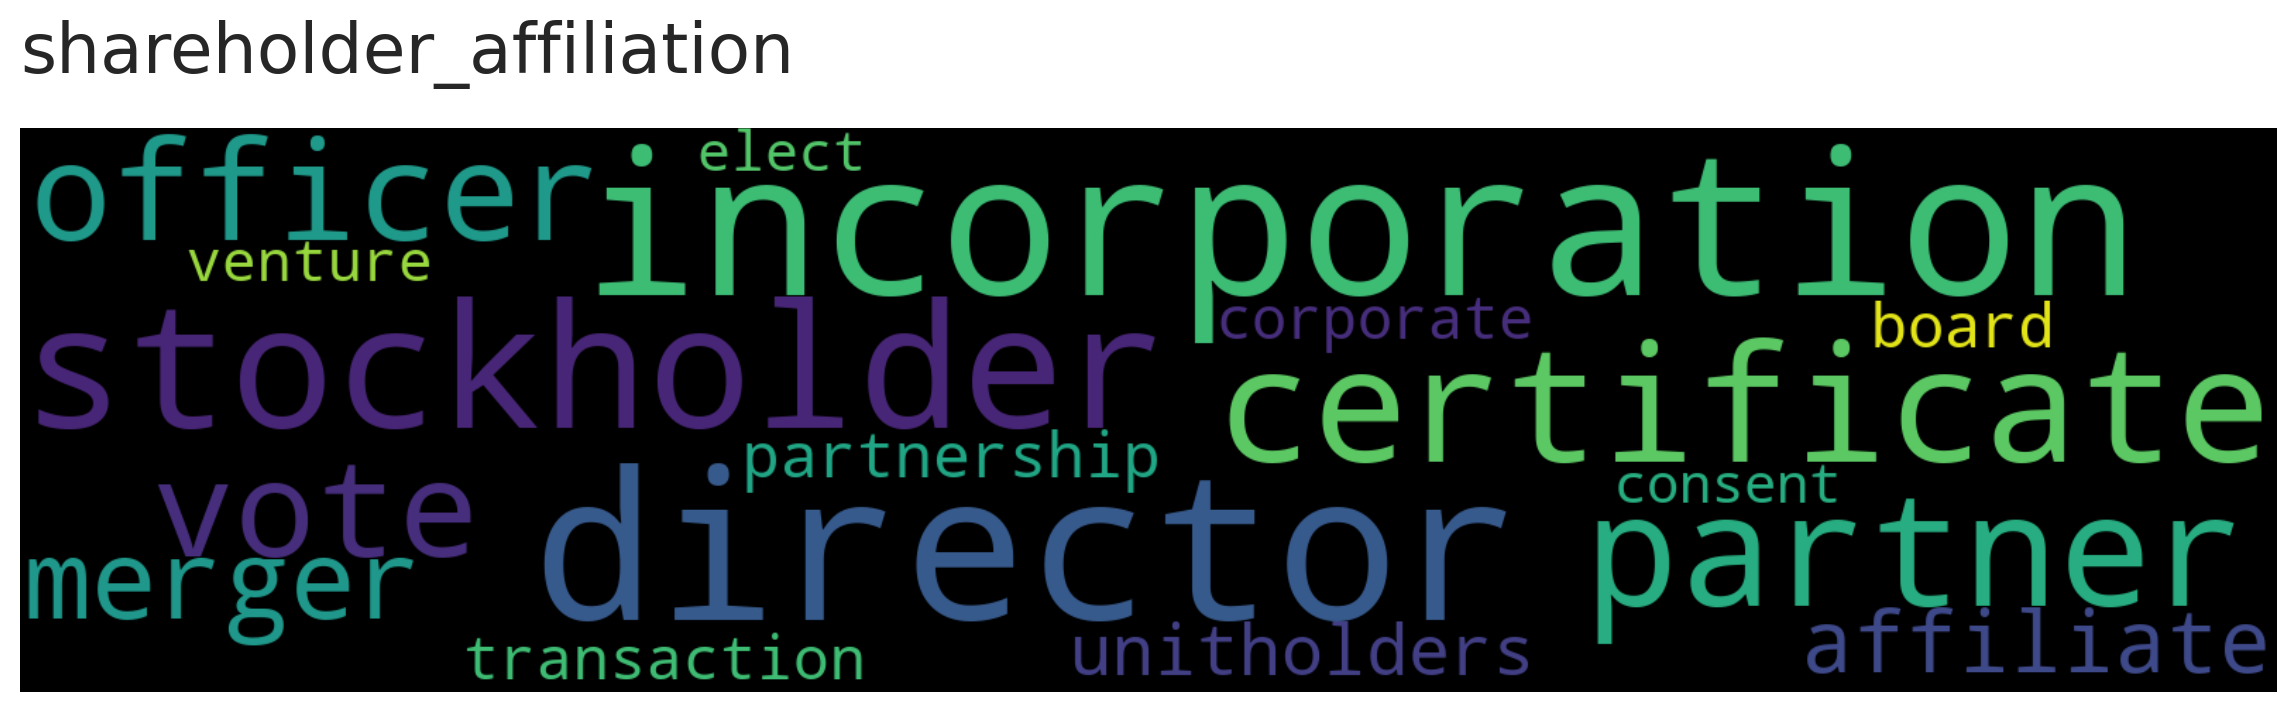

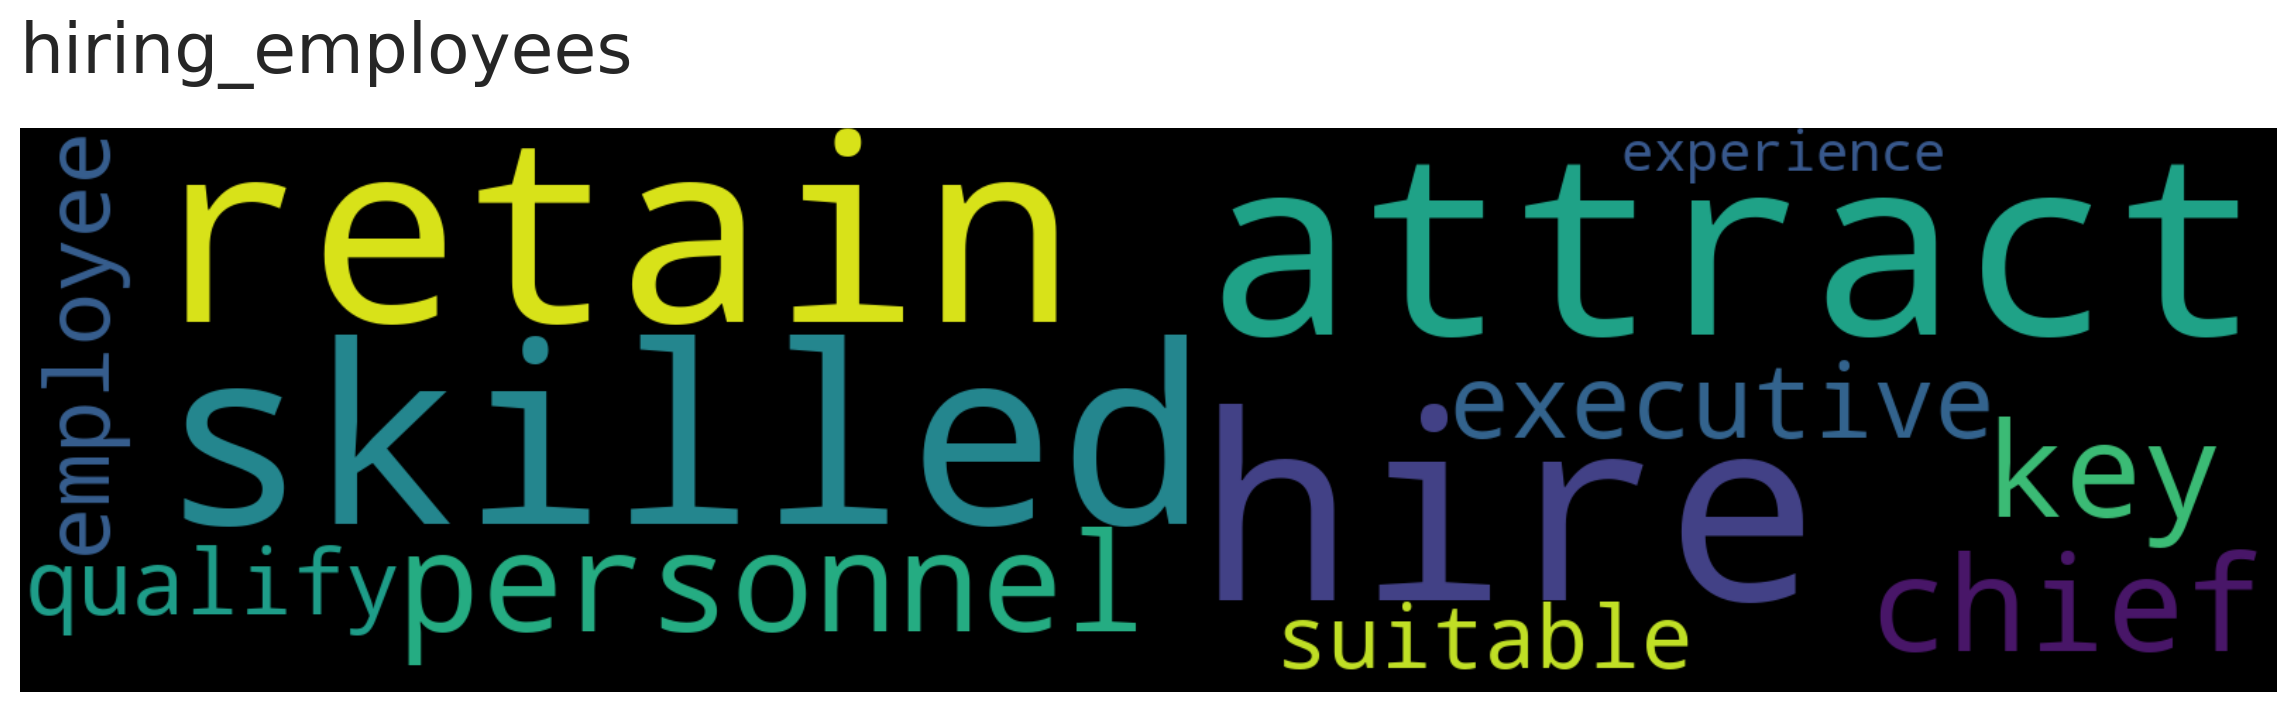

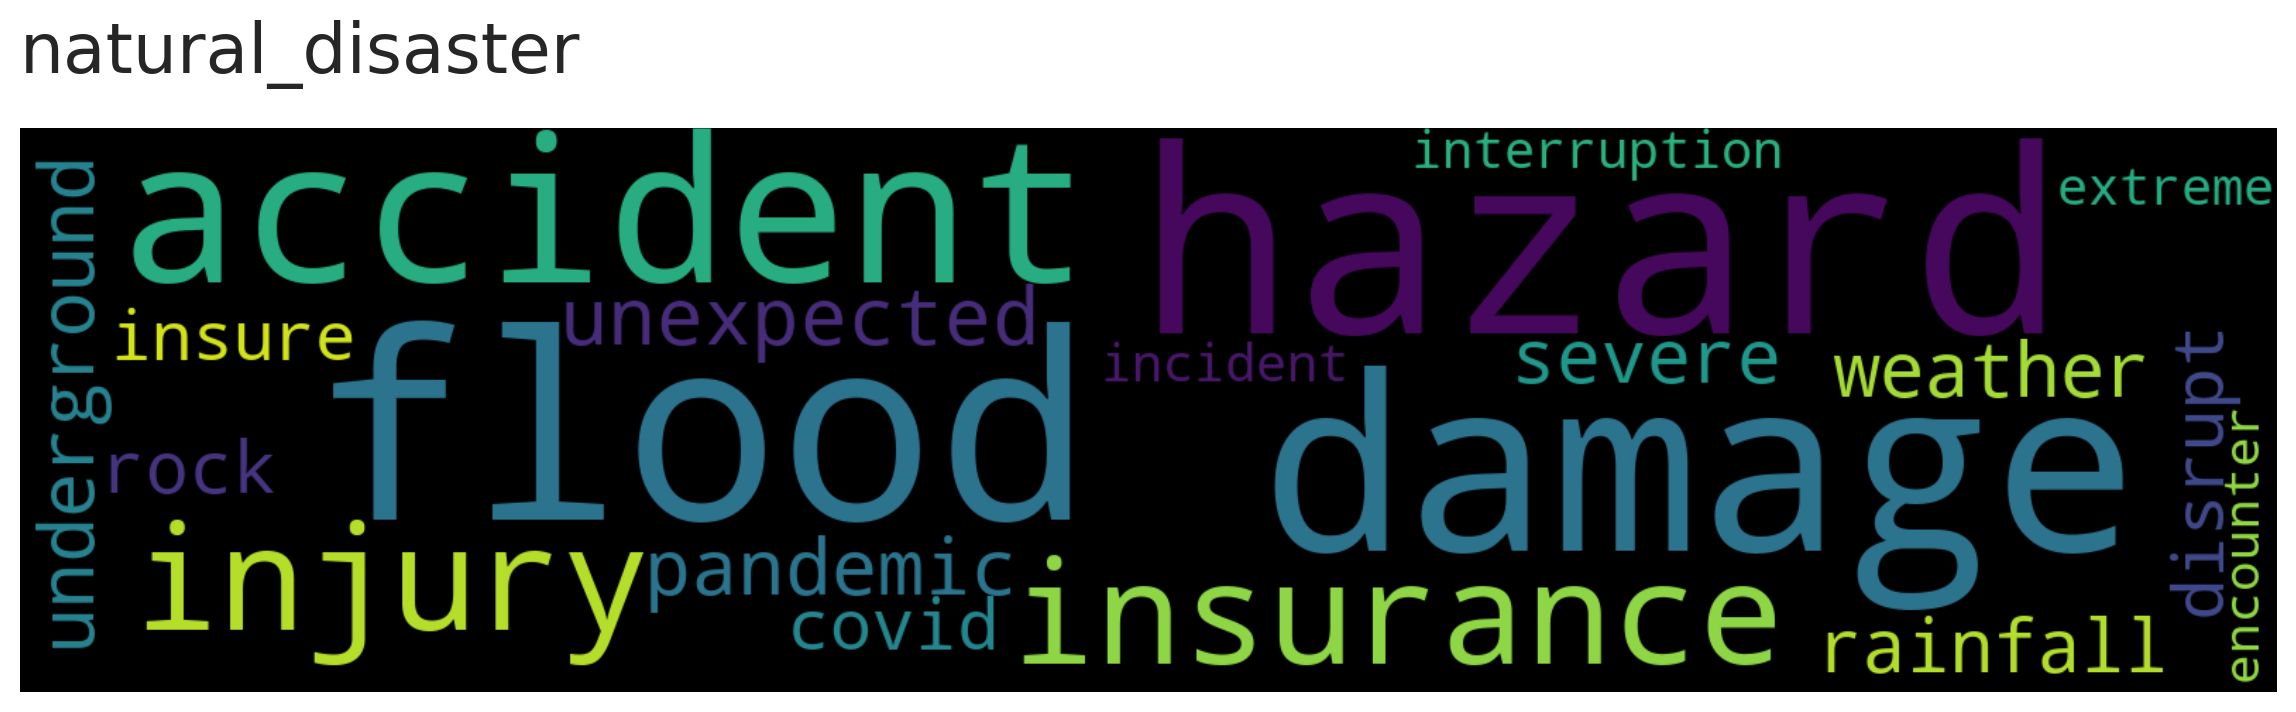

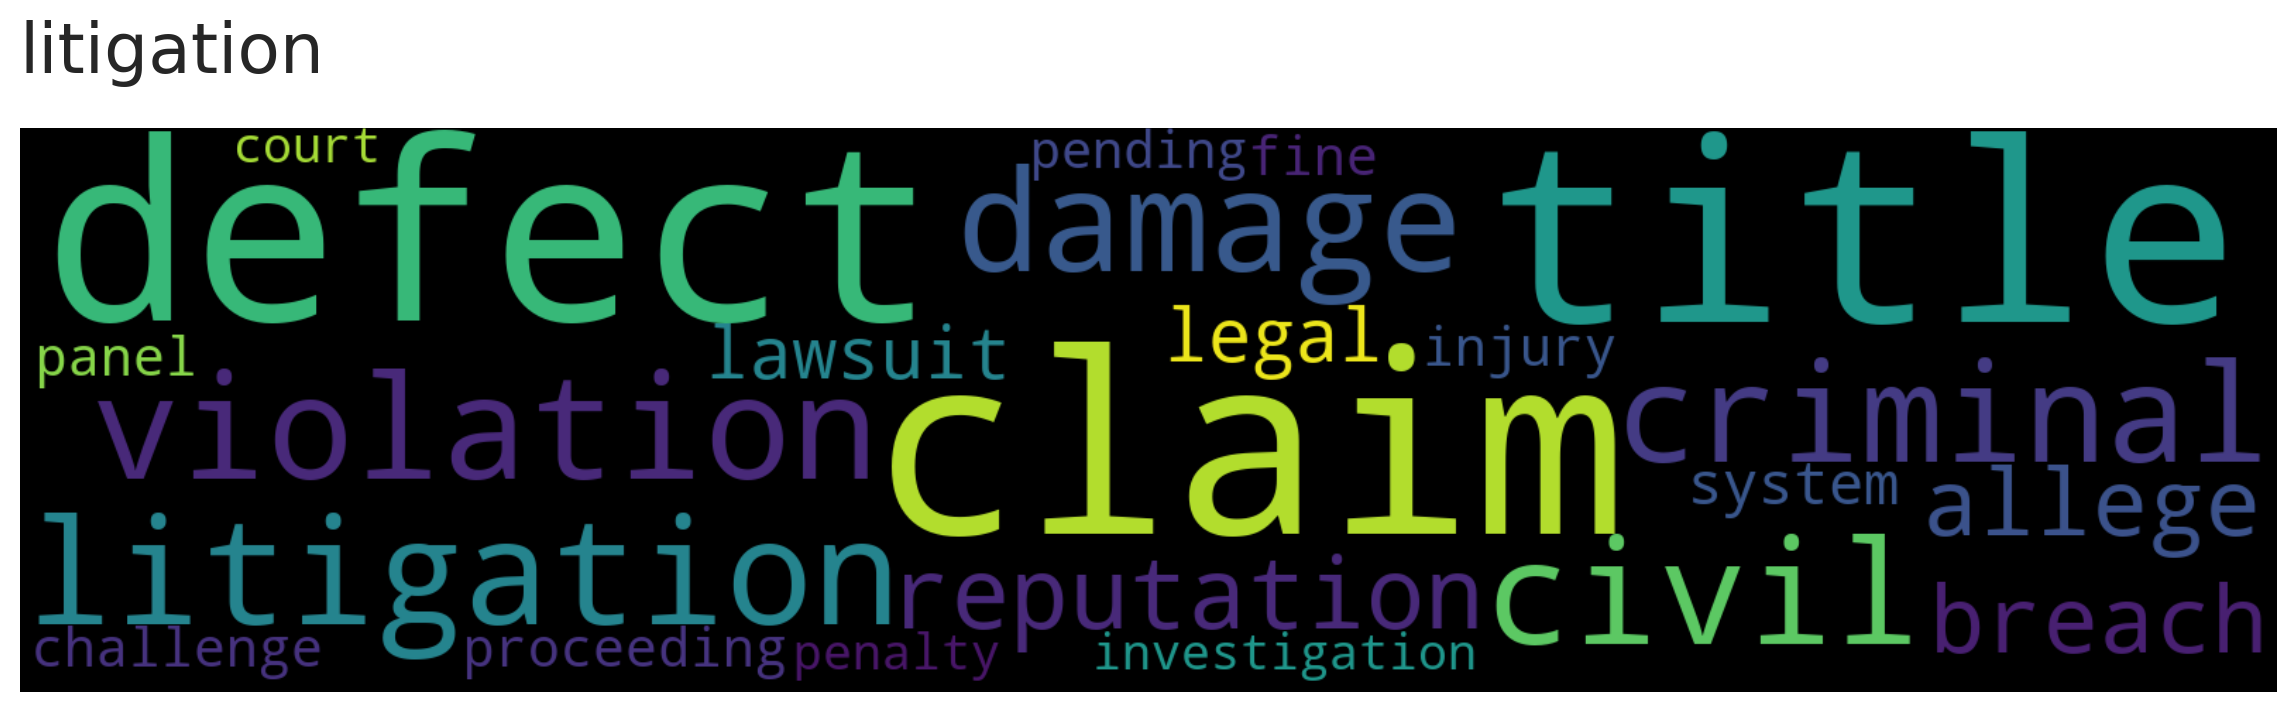

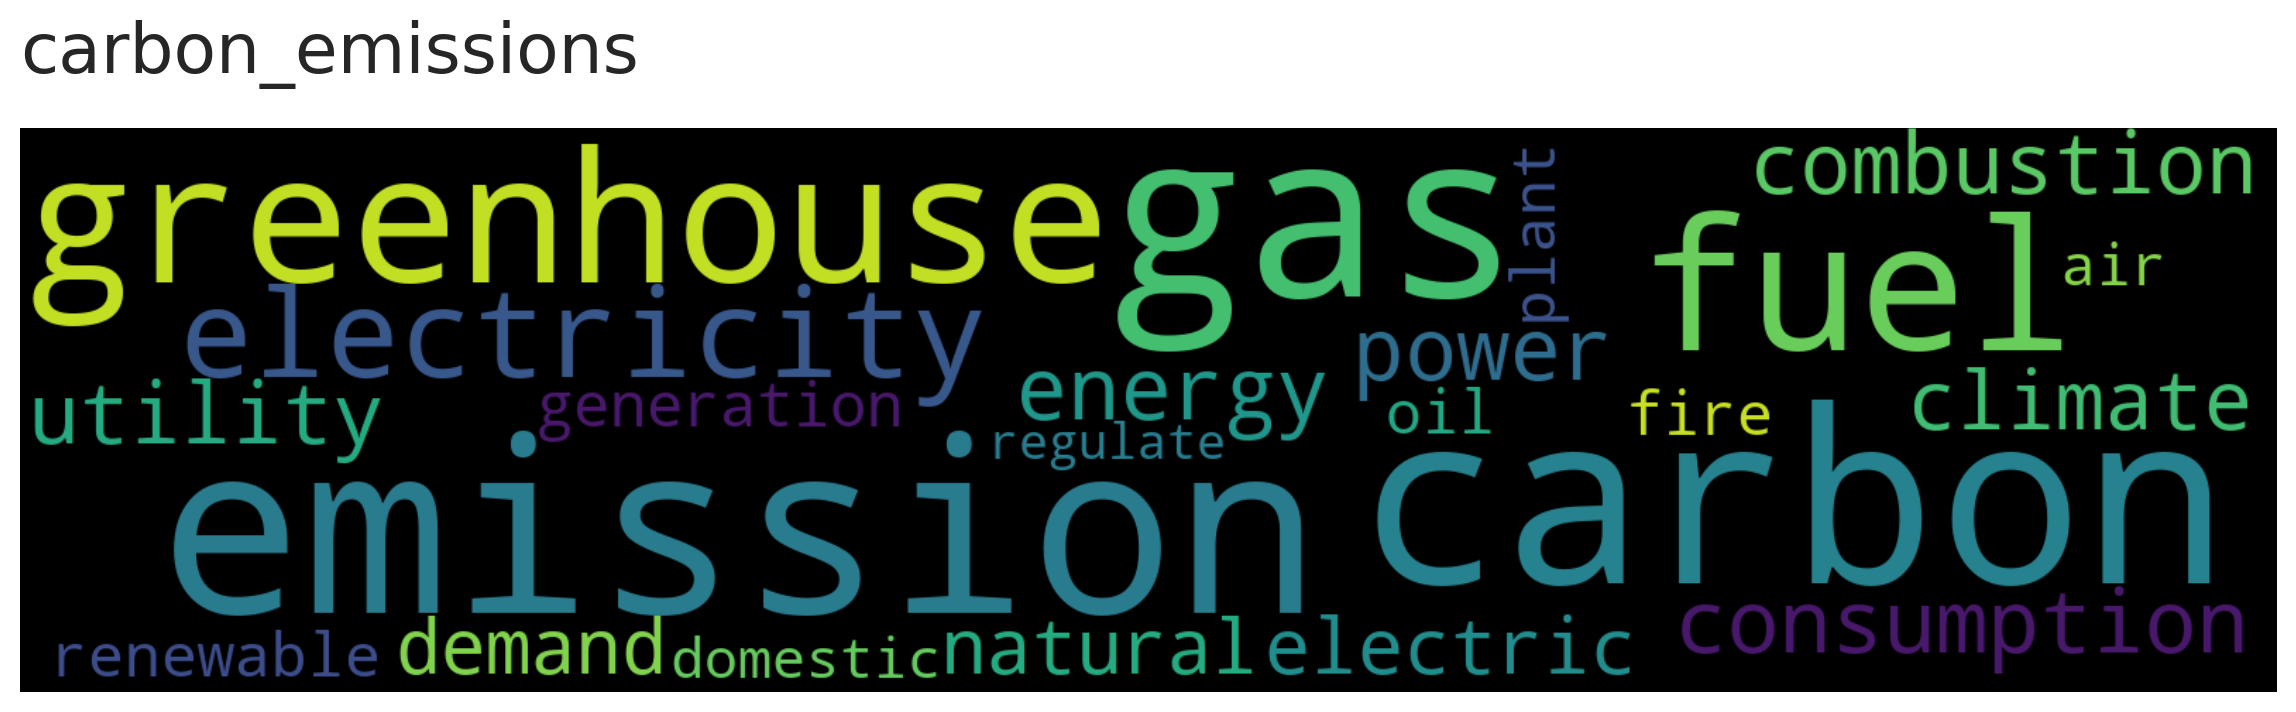

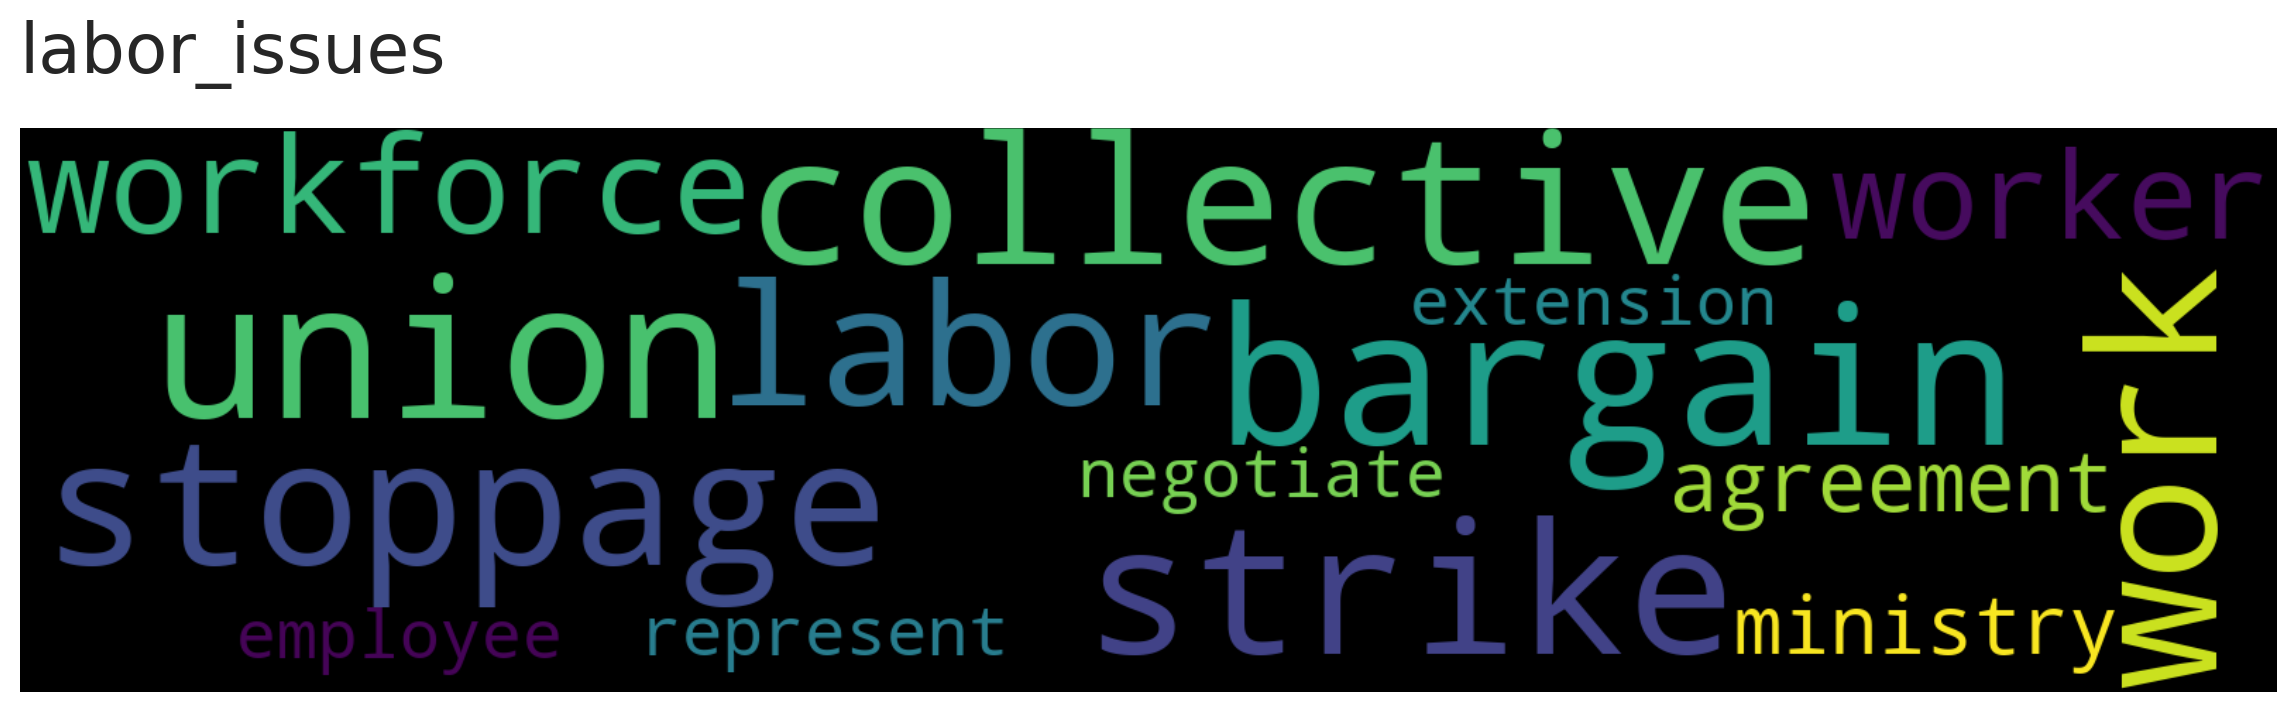

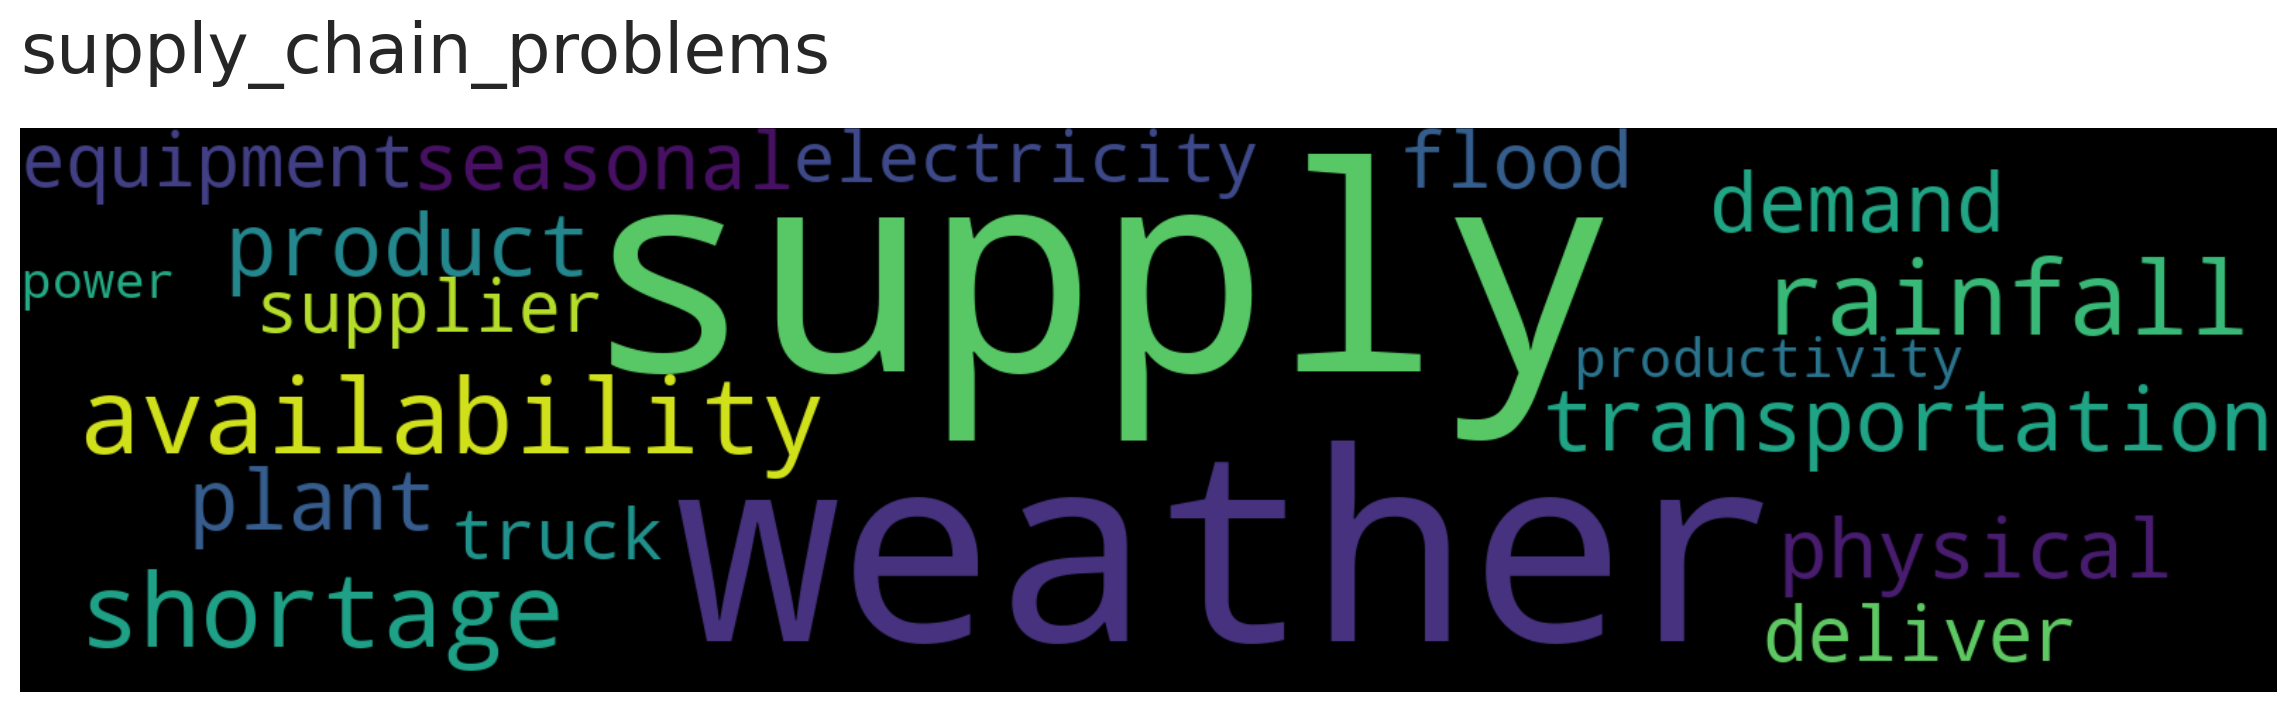

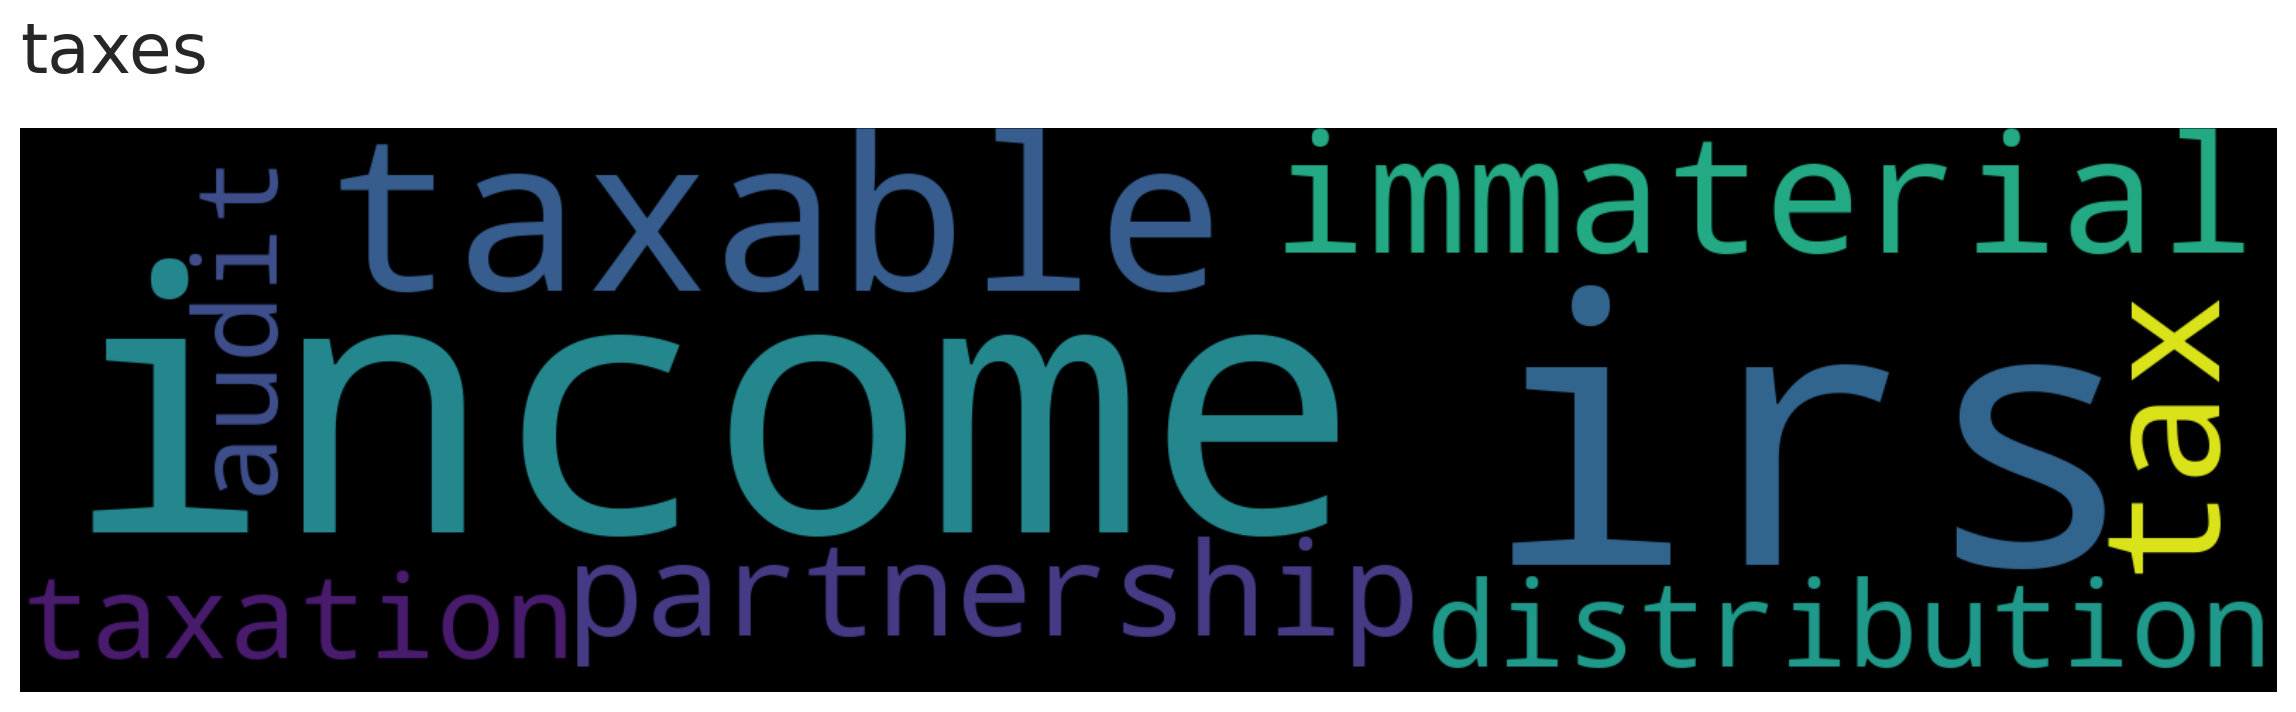

In [7]:
# Re-generate wordclouds for the trimmed topics
for tid in topic_words["topic_num"].unique():
    topic_word_freq = {row.keyword: row.cosine_score for row in 
                            topic_words.loc[topic_words["topic_num"] == tid].itertuples()}
    generate_wordcloud(topic_word_freq, topic_itos_cluster[tid])

### __Top2Vec Cluster Topics Assignment__

In [ ]:
topic_bags = topic_words[["topic_num", "keyword"]] \
                .groupby("topic_num") \
                .agg(list) \
                .reset_index() \
                .sort_values("topic_num")["keyword"] \
                .values.tolist()

# Augment topic bags with similar words using FastText embeddings
for i, (tn, ti) in zip(range(len(topic_bags)), topic_stoi_cluster.items()):
    topic_bags[i] = topic_bags[i] + get_similar_words_fasttext(topic_bags[i] , thresh=0.65)
    topic_bags[i] = list(set(tokenize_text(" ".join(topic_bags[i]))))
    print(f"Topic ({ti:2d} - {tn}): {', '.join(topic_bags[i])}")

In [8]:
# Load re-trimmed augmented topic words
topic_words = pd.read_csv(paths.data / "topics" / "topic_words_cluster_aug_to_trim_th.csv")
topic_words = topic_words.loc[topic_words["drop_th"] != 1]
topic_bags = topic_words[["topic_num", "keyword"]] \
                .groupby("topic_num") \
                .agg(list) \
                .reset_index() \
                .sort_values("topic_num")["keyword"] \
                .values.tolist()

for i, (tn, ti) in zip(range(len(topic_bags)), topic_stoi_cluster.items()):
    print(f"Topic ({ti:2d} - {tn}): {', '.join(topic_bags[i])}")

Topic ( 4 - customer_orientation): sales, business, price, products, industry, company, supplier, prices, marketing, profits, investment, markets, production, buyer, pricing, commodity, seller, suppliers, manufacturing, profit, customers, consumer, enterprise, revenues, goods, commercial, selling, purchaser, retailer, brand, trade, competitors, customer, demand, sale, margin, revenue, product, manufacturer, retail, downturn, competitor, producer, supply, competition, sell, domestic, profitability, market
Topic ( 6 - shareholder_affiliation): corporation, shareholder, business, company, shareholders, directors, partners, investment, agreement, executive, management, election, government, director, incorporation, stockholder, certificate, partner, officer, vote, merger, affiliate, unitholders, partnership, board, transaction, corporate, venture, elect, consent
Topic ( 8 - hiring_employees): staff, recruit, employ, hire, retain, skilled, personnel, executive, employee, experience
Topic ( 

In [9]:
predict_topic_fn = t2v_viewer.make_fasttext_keyword_predictor(topic_bags=topic_bags, thresh_matching=0.65)
normalization_fn = lambda ss: ss  # No text normalization

# predict_topic_fn = t2v_viewer.make_sbert_predictor(topic_bags=topic_bags, model_bert="all-MiniLM-L12-v2")  # thresh=0.35
# normalization_fn = lambda ss: [" ".join(tokenize_text(s)) for s in ss]  # Text normalization
# df_test["topic_ids_cluster"] = df_test["item1a_sentences"].progress_apply(lambda ss: predict_topic_fn(normalization_fn(ss), thresh=2))

df_10k["topic_ids_cluster"] = df_10k["item1a_sentences"].progress_apply(lambda ss: predict_topic_fn(normalization_fn(ss), thresh=2.0))

100%|██████████| 367/367 [09:31<00:00,  1.56s/it]


In [11]:
df_test = df_10k.sample(4, random_state=42)
samples = []
for ss, tss in zip(df_test["item1a_sentences"], df_test["topic_ids_cluster"]):
    for s, ts in zip(ss, tss):
        topic_names = []
        for t in ts:
            if t >= 0:
                topic_names.append(topic_itos_cluster[id_map_cluster[t]])
        if topic_names:
            samples.append({"tag_names": ", ".join(topic_names), "sentence": s})

for s in samples:
    pprint(s["sentence"])
    print(f'- {s["tag_names"]}', end="\n\n")

('You should carefully consider the following risk factors, in addition to '
 'those discussed elsewhere in this report, in evaluating our Company, its '
 'business, its industry and prospects.')
- customer_orientation

('Because we may never earn significant revenues from our mine operations, our '
 'business may fail.')
- taxes

('If our business plan is not successful and we are not able to operate '
 'profitably, then our securities may become worthless and investors may lose '
 'all of their investment in our Company.')
- customer_orientation, shareholder_affiliation

('We recognize that if we are unable to generate significant revenues from the '
 'exploration and exploitation of our mineralized materials in the future, we '
 'will not be able to earn profits or continue operations.')
- taxes

('There is no history upon which to base any assumption as to the likelihood '
 'that we will prove successful, and we can provide no assurance that we will '
 'generate significant revenue

### __Pillar Topics (ESG) Assignment__

In [ ]:
# Load pillar topic words
topic_words = pd.read_excel(paths.data / "topics" / "MSCI keywords.xlsx", usecols=["Pillar", "Keywords"]) \
                .fillna(method="ffill") \
                .rename(columns={"Keywords": "keyword", "Pillar": "topic_name"}) \
                .apply(lambda x: x.str.lower().str.strip()) \
                .assign(topic_num=lambda x: x["topic_name"].map(lambda t: topic_stoi_pillar[t])) \
                .groupby(["topic_num", "topic_name"]) \
                .agg({"keyword": lambda x: re.split(r",\s|\s", ", ".join(x))}) \
                .reset_index()
topic_bags = topic_words.sort_values("topic_num")["keyword"].values.tolist()

# Augment topic bags with similar words using FastText embeddings
for i, (tn, ti) in zip(range(len(topic_bags)), topic_stoi_pillar.items()):
    topic_bags[i] = [tn] + topic_bags[i]
    topic_bags[i] = topic_bags[i] + get_similar_words_fasttext(topic_bags[i], top_k=30, thresh=0.7)
    topic_bags[i] = list(set(tokenize_text(" ".join(topic_bags[i]))))
    print(f"Topic ({ti:2d} - {tn}): {', '.join(topic_bags[i])}")

In [12]:
# Load BBK topic words
topic_words_bbk = pd.read_excel(paths.data / "topics" / "BaierBerningerKiesel_ESG-Wordlist_2020_July22.xlsx", sheet_name="ESG-Wordlist") \
                    .rename(columns={"Word": "keyword", "Topic": "topic_name"}) \
                    .apply(lambda x: x.str.lower().str.strip()) \
                    .assign(topic_num=lambda x: x["topic_name"].map(lambda t: topic_stoi_pillar[t])) \
                    .loc[:, ["topic_num", "topic_name", "keyword"]]

# Load re-trimmed augmented topic words
topic_words = pd.read_csv(paths.data / "topics" / "topic_words_pillar_aug_to_trim_th.csv")
topic_words = topic_words.loc[topic_words["drop_th"] != 1, ["topic_num", "topic_name", "keyword"]]
topic_words = pd.concat([topic_words, topic_words_bbk], ignore_index=True).reset_index(drop=True)

# Construct topic bags
topic_bags = topic_words[["topic_num", "keyword"]] \
                .groupby("topic_num") \
                .agg(list) \
                .reset_index() \
                .sort_values("topic_num")["keyword"] \
                .values.tolist()

for i, (tn, ti) in zip(range(len(topic_bags)), topic_stoi_pillar.items()):
    print(f"Topic ({ti:2d} - {tn}): {', '.join(topic_bags[i])}")

Topic ( 0 - environmental): ecological, environment, nature, health, ecology, resource, conservation, sustainability, carbon, emissions, carbon, carbon, clean, energy, carbon, carbon, environmental, green, climate, climate, environmental, environmental, water, water, water, biodiversity, land, ecosystems, marine, biodiversity, agricultural, sustainable, aquaculture, timber, toxic, emissions, toxic, water, pollution, contamination, carcinogens, smog, waste, recycling, waste, clean, environmental, green, environmental, green, green, sustainable, renewable, energy, alternative, energy, energy, efficiency, wind, energy, solar, energy, biomass, energy, hydro, energy, smart, hybrid, carbon, clean, environmental, epa, sustainability, climate, warming, biofuel, biofuels, green, renewable, solar, stewardship, wind, atmosphere, emission, emissions, emit, ghg, ghgs, greenhouse, agriculture, deforestation, pesticide, pesticides, wetlands, zoning, biodiversity, species, wilderness, wildlife, freshw

In [13]:
predict_topic_fn = t2v_viewer.make_fasttext_keyword_predictor(topic_bags=topic_bags, thresh_matching=0.65)
normalization_fn = lambda ss: ss  # No text normalization

# predict_topic_fn = t2v_viewer.make_sbert_predictor(topic_bags=topic_bags, model_bert="all-MiniLM-L12-v2")  # thresh=0.3
# normalization_fn = lambda ss: [" ".join(tokenize_text(s)) for s in ss]  # Text normalization
# df_test["topic_ids_pillar"] = df_test["item1a_sentences"].progress_apply(lambda ss: predict_topic_fn(normalization_fn(ss), thresh=2))

df_10k["topic_ids_pillar"] = df_10k["item1a_sentences"].progress_apply(lambda ss: predict_topic_fn(normalization_fn(ss), thresh=2))

100%|██████████| 367/367 [08:19<00:00,  1.36s/it]


In [14]:
df_test = df_10k.sample(4, random_state=42)
samples = []
for ss, tss in zip(df_test["item1a_sentences"], df_test["topic_ids_pillar"]):
    for s, ts in zip(ss, tss):
        topic_names = []
        for t in ts:
            if t >= 0:
                topic_names.append(topic_itos_pillar[id_map_pillar[t]])
        if topic_names:
            samples.append({"tag_names": ", ".join(topic_names), "sentence": s})

for s in samples:
    pprint(s["sentence"])
    print(f'- {s["tag_names"]}', end="\n\n")

('You should carefully consider the following risk factors, in addition to '
 'those discussed elsewhere in this report, in evaluating our Company, its '
 'business, its industry and prospects.')
- governance

('In that case, the market price of our securities could decline, and you '
 'could lose part or all of your investment.')
- governance

('If our business plan is not successful and we are not able to operate '
 'profitably, then our securities may become worthless and investors may lose '
 'all of their investment in our Company.')
- governance

('If we are unsuccessful in addressing these risks, our business will fail and '
 'investors may lose all of their investment in our Company.')
- governance

('Transportation difficulties and weather interruptions may affect and delay '
 'proposed mining operations and impact our business plans.')
- governance

('Our mineral projects involve high risks because we have not invested '
 'sufficiently in the characterization of mineralized m

### __Predict if Describing an Action Taken__

In [ ]:
predict_action_fn = make_setfit_binary_predictor(str(paths.model / "sentence-transformers/all-MiniLM-L12-v2-actions-aug"))
df_10k["is_action_probas"] = df_10k["item1a_sentences"].progress_apply(lambda ss: predict_action_fn(ss, return_probas=True))

In [15]:
df_test = df_10k.sample(4, random_state=42)
samples = []
for row in df_test.itertuples():
    for s, a, t in zip(row.item1a_sentences, row.is_action_probas, row.topic_ids_cluster):
        samples.append((a, s.replace("\n", ""), t))
samples.sort(key=lambda x: x[0], reverse=True)
for s in samples[:100]:
    if s[2][0] >= 0:
        print(f"[ {s[0]:.2f} ] {s[1]} {s[2]}")

[ 0.99 ] We have agreed to guarantee Magnums obligations to supply coal under certain coal sales contracts that we sold to Magnum. [0]
[ 0.98 ] We are presently licensed by Sun Microsystems and Silicon Graphics to sell memory products for certain of their products. [0]
[ 0.98 ] Because of the shortage of trained coal miners in recent years, we have operated certain facilities without full staff and have hired novice miners, who are required to be accompanied by experienced workers as a safety precaution. [2]
[ 0.98 ] In addition to selling server memory systems, we develop, manufacturer and market a variety of memory products for motherboards that are Intel or AMD processor based. [0, 7]
[ 0.97 ] We expect to renew, extend or enter into new long-term coal supply agreements with those and other customers. [0]
[ 0.97 ] At such times we have bought DRAMs in excess of our customers' needs in order to ensure future allocations from DRAM manufacturers. [0]
[ 0.97 ] Prior to making any distri

In [ ]:
# Free up CUDA memory
del predict_action_fn

## __Compute Statistics__

In [16]:
def compute_statistics(row: pd.Series) -> pd.Series:
    ret = {
        "topic_names_cluster": [],
        "topic_names_pillar": [],
        "n_sentences": 0,
        "n_actions": 0,
        "n_sentences_topic_cluster_total": 0,
        "n_actions_topic_cluster_total": 0,
        "n_sentences_topic_pillar_total": 0,
        "n_actions_topic_pillar_total": 0,
    }

    for tn in topic_itos_cluster.values():
        ret[f"n_sentences_topic_cluster_{tn}"] = 0
        ret[f"n_actions_topic_cluster_{tn}"] = 0

    for tn in topic_itos_pillar.values():
        ret[f"n_sentences_topic_pillar_{tn}"] = 0
        ret[f"n_actions_topic_pillar_{tn}"] = 0

    for tis_cluster, tis_pillar, proba_action in zip(
        row.topic_ids_cluster, row.topic_ids_pillar, row.is_action_probas
    ):
        ret["n_sentences"] += 1
        ret["n_actions"] += int(proba_action >= 0.5)

        tns_cluster = []
        for ti in tis_cluster:
            tn = topic_itos_cluster[id_map_cluster[ti]]
            if ti >= 0:
                tns_cluster.append(tn)
                ret[f"n_sentences_topic_cluster_{tn}"] += 1
                ret[f"n_actions_topic_cluster_{tn}"] += int(proba_action >= 0.5)
            else:
                tns_cluster.append("null")
        ret["topic_names_cluster"].append(", ".join(tns_cluster))

        tns_pillar = []
        for ti in tis_pillar:
            tn = topic_itos_pillar[id_map_pillar[ti]]
            if ti >= 0:
                tns_pillar.append(tn)
                ret[f"n_sentences_topic_pillar_{tn}"] += 1
                ret[f"n_actions_topic_pillar_{tn}"] += int(proba_action >= 0.5)
            else:
                tns_pillar.append("null")
        ret["topic_names_pillar"].append(", ".join(tns_pillar))

    for tn in topic_itos_cluster.values():
        ret["n_sentences_topic_cluster_total"] += ret[f"n_sentences_topic_cluster_{tn}"]
        ret["n_actions_topic_cluster_total"] += ret[f"n_actions_topic_cluster_{tn}"]

    for tn in topic_itos_pillar.values():
        ret["n_sentences_topic_pillar_total"] += ret[f"n_sentences_topic_pillar_{tn}"]
        ret["n_actions_topic_pillar_total"] += ret[f"n_actions_topic_pillar_{tn}"]

    return pd.Series(ret)


def explode_sentences_attributes(row: pd.Series) -> pd.DataFrame:
    ret = []
    for text, tns_cluster, tns_pillar, proba_action in zip(
        row.item1a_sentences, row.topic_names_cluster, 
        row.topic_names_pillar, row.is_action_probas
    ):
        ret.append(
            {
                "symbol": row.symbol,
                "filing_time": row.filing_time,
                "sentence": text,
                "topic_names_cluster": tns_cluster,
                "topic_names_pillar": tns_pillar,
                "is_action_proba": proba_action,
            }
        )
    return pd.DataFrame(ret)


df_10k_statistics = df_10k.progress_apply(compute_statistics, axis=1)
df_10k_statistics = df_10k.join(df_10k_statistics)
df_10k_statistics.head()

100%|██████████| 367/367 [00:00<00:00, 1181.34it/s]


,symbol,filing_time,item1a,status,keywords,entities,noun_chunks,top8_key,top8_key_scr_all,top8_key_scr_avg,...,n_sentences_topic_cluster_supply_chain_problems,n_actions_topic_cluster_supply_chain_problems,n_sentences_topic_cluster_taxes,n_actions_topic_cluster_taxes,n_sentences_topic_pillar_environmental,n_actions_topic_pillar_environmental,n_sentences_topic_pillar_social,n_actions_topic_pillar_social,n_sentences_topic_pillar_governance,n_actions_topic_pillar_governance
0,abml,2013-12-01,[The Risk Factors below are provided for a pot...,0,"[locate, think, call, lose, assurance, result,...","[oroplata, bylaw article incorporation, minist...","[government regulation, occasional spot shorta...","[accept, devote, hire, express, factor, achiev...","[24.00, 30.00, 3.00, 34.00, 8.00, 33.00, 17.00...",22.88,...,5,1,2,0,5,0,10,3,30,4
1,abml,2015-01-01,[The Risk Factors below are provided for a pot...,0,"[locate, lose, result, estimate, predict, slow...","[oroplata, mineral property, bylaw article inc...","[new mineral interest, material effect, near f...","[hire, factor, share, accept, express, devote,...","[3.00, 8.00, 17.00, 24.00, 34.00, 30.00, 41.00...",25.00,...,5,1,0,0,3,0,9,3,27,4
2,abml,2015-12-01,[We are a smaller reporting company as defined...,0,[],[security act],"[smaller reporting company, security act]","[pay, pass, penetrate, pende, perform, patent,...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,...,0,0,0,0,0,0,0,0,0,0
3,abml,2016-12-01,[We are a smaller reporting company as defined...,0,[],[security act],"[smaller reporting company, security act]","[pay, pass, penetrate, pende, perform, patent,...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,...,0,0,0,0,0,0,0,0,0,0
4,abml,2018-01-01,[Not required..],0,[require],[],[],"[penetrate, pay, perceive, require, permit, pe...","[368.00, 368.00, 368.00, 352.00, 368.00, 368.0...",366.00,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_10k_statistics \
    .filter(regex=r"symbol|filing_time|n_(sentences|actions)") \
    .to_csv(paths.item1a / "processed" / "item1a_topic_statistics_fasttext.csv", index=False)

In [18]:
df_10k_sentences = df_10k_statistics.apply(explode_sentences_attributes, axis=1).tolist()
df_10k_sentences = pd.concat(df_10k_sentences, ignore_index=True)
df_10k_sentences.head()

,symbol,filing_time,sentence,topic_names_cluster,topic_names_pillar,is_action_proba
0,abml,2013-12-01,The Risk Factors below are provided for a pote...,null,null,0.097676
1,abml,2013-12-01,There is a high degree of risk in the purchase...,customer_orientation,null,0.063647
2,abml,2013-12-01,"If any of the following risk materialize, it c...",null,null,0.008687
3,abml,2013-12-01,A potential investor must be aware that he or ...,null,governance,0.026769
4,abml,2013-12-01,Risks Factors Which May Effect Our Business Be...,null,governance,0.020413


In [19]:
df_10k_sentences.to_csv(paths.item1a / "processed" / "item1a_topic_sentences_fasttext.csv", index=False)

In [20]:
sec10k_loader.flush_processed(df_10k, "item1a_with_attributes_fasttext.json")

,symbol,filing_time,item1a,status,keywords,entities,noun_chunks,top8_key,top8_key_scr_all,top8_key_scr_avg,...,top8_ent_scr_avg,top8_ent_scr_min,top8_nck,top8_nck_scr_all,top8_nck_scr_avg,top8_nck_scr_min,item1a_sentences,topic_ids_cluster,topic_ids_pillar,is_action_probas
0,abml,2013-12-01,[The Risk Factors below are provided for a pot...,0,"[locate, think, call, lose, assurance, result,...","[oroplata, bylaw article incorporation, minist...","[government regulation, occasional spot shorta...","[accept, devote, hire, express, factor, achiev...","[24.00, 30.00, 3.00, 34.00, 8.00, 33.00, 17.00...",22.88,...,4.88,1,"[general economic political market condition, ...","[3.00, 3.00, 3.00, 3.00, 3.00, 3.00, 3.00, 3.00]",3.00,3,[The Risk Factors below are provided for a pot...,"[[-1], [0], [-1], [-1], [-1], [-1], [-1], [0, ...","[[-1], [-1], [-1], [2], [2], [-1], [-1], [2], ...","[0.0976758732, 0.0636468605, 0.0086866519, 0.0..."
1,abml,2015-01-01,[The Risk Factors below are provided for a pot...,0,"[locate, lose, result, estimate, predict, slow...","[oroplata, mineral property, bylaw article inc...","[new mineral interest, material effect, near f...","[hire, factor, share, accept, express, devote,...","[3.00, 8.00, 17.00, 24.00, 34.00, 30.00, 41.00...",25.00,...,3.50,1,"[cash need, commercially exploitable reserve, ...","[3.00, 3.00, 3.00, 3.00, 3.00, 3.00, 3.00, 4.00]",3.12,3,[The Risk Factors below are provided for a pot...,"[[-1], [0], [-1], [-1], [-1], [-1], [-1], [0, ...","[[-1], [-1], [-1], [2], [2], [-1], [-1], [2], ...","[0.057949447, 0.0636468605, 0.0086866519, 0.02..."
2,abml,2015-12-01,[We are a smaller reporting company as defined...,0,[],[security act],"[smaller reporting company, security act]","[pay, pass, penetrate, pende, perform, patent,...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,...,325.75,30,"[party site, party source, security act, party...","[368.00, 368.00, 16.00, 368.00, 368.00, 17.00,...",280.12,16,[We are a smaller reporting company as defined...,[[-1]],[[-1]],[0.496934639]
3,abml,2016-12-01,[We are a smaller reporting company as defined...,0,[],[security act],"[smaller reporting company, security act]","[pay, pass, penetrate, pende, perform, patent,...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,...,325.75,30,"[party site, party source, security act, party...","[368.00, 368.00, 16.00, 368.00, 368.00, 17.00,...",280.12,16,[We are a smaller reporting company as defined...,[[-1]],[[-1]],[0.496934639]
4,abml,2018-01-01,[Not required..],0,[require],[],[],"[penetrate, pay, perceive, require, permit, pe...","[368.00, 368.00, 368.00, 352.00, 368.00, 368.0...",366.00,...,368.00,368,"[party site, party source, party processing ac...","[368.00, 368.00, 368.00, 368.00, 368.00, 368.0...",368.00,368,[Not required..],[[-1]],[[-1]],[0.5228199227]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,xpl,2018-03-01,[In addition to considering the other informat...,0,"[locate, know, maintain, subject, account, los...","[, latin america, montana, foreign corrupt pra...","[following factor, material risk, near future,...","[sign, form, look, understand, invest, achieve...","[54.00, 30.00, 37.00, 6.00, 31.00, 33.00, 20.0...",33.38,...,2.75,1,"[u.s. tax reform, extensive additional explora...","[4.00, 3.00, 4.00, 4.00, 4.00, 3.00, 4.00, 3.00]",3.62,3,[In addition to considering the other informat...,"[[-1], [-1], [-1], [1], [-1], [-1], [-1], [-1]...","[[-1], [-1], [-1], [-1], [-1], [-1], [-1], [-1...","[0.1674313138, 0.0194540941, 0.0090802242, 0.0..."
363,xpl,2019-03-01,[In addition to considering the other informat...,0,"[locate, know, maintain, subject, account, los...","[, latin america, montana, u.s. foreign corrup...","[following factor, material risk, near future,...","[hedge, invest, act, recover, look, form, pose...","[56.00, 31.00, 20.00, 60.00, 37.00, 30.00, 63....",45.00,...,6.62,2,"[particularly zinc, charles schwab, fdic insur...","[3.00, 4.